In [1]:
import nbimporter

# Import main functionality
#from GPDM_direct_fixedpoints import *
from thesis_Experiment_2d_MachensBrody import *

plotly.offline.init_notebook_mode(connected=True)

# Saving outputs and timing
import pickle, datetime, time

from joblib import Parallel, delayed
import multiprocessing
import itertools

Importing Jupyter notebook from thesis_Experiment_2d_MachensBrody.ipynb
Importing Jupyter notebook from GPDM_direct_fixedpoints.ipynb


In [2]:
# Installing packages
# import sys
# # !conda install --yes --prefix {sys.prefix} <PKGNAME>

In [3]:
def save_csv(fname, arr):
    f_handle = open("Figures/CSV/"+fname, 'wb')
    np.savetxt(f_handle, arr, delimiter=",")
    f_handle.close()

# Load the data and fits

In [4]:
data_loading_uneven = scipy.io.loadmat('thesis_Machens_Brody_sim/thesis_MachensBrodySim_20181230T121236_loading_uneven.mat', squeeze_me=True)
data_loading_even = scipy.io.loadmat('thesis_Machens_Brody_sim/thesis_MachensBrodySim_20181230T121236_loading_even.mat', squeeze_me=True)
data_decision = scipy.io.loadmat('thesis_Machens_Brody_sim/thesis_MachensBrodySim_20181230T121236_decision.mat', squeeze_me=True)

In [5]:
GP_fit_saves = [
    pickle.load(open('Experiment_machens_results/' + save_fname, 'rb')) for save_fname in [
        'machens_decision_20190421T040311.pkl',
        'machens_loading_even_20190421T171829.pkl',
        'machens_loading_uneven_20190421T053043.pkl',
    ]
]

In [6]:
# Scale the nullclines (originally defined in the space of electric conductances), 
# such that they follow the transformed data after adding spiking and calcium imaging

scalings = list()
for dataset_name in ['data_loading_even', 'data_decision', 'data_loading_uneven']:
    if dataset_name=='data_decision':
        cur_data=data_decision
        cur_simParams = GP_fit_saves[0][3]
    if dataset_name=='data_loading_even':
        cur_data=data_loading_even
        cur_simParams = GP_fit_saves[1][3]
    if dataset_name=='data_loading_uneven':
        cur_data=data_loading_uneven
        cur_simParams = GP_fit_saves[2][3]

    # Then take into account calcium dynamics and binning for the true nullcline 

    # Get the calcium convultion kernel
    conv_t, conv_weights = fred_curve(cur_simParams['fred_params'])

    # Get average contribution to deltaF/F relative fluoresecence increase per spike per frame
    # (essentially I pick points randomly on the convolution curve per frame - due to instantaneous sampling via Ca imaging)
    # , and want to know the expected value of % fluorescence increase per frame, given a single uniformly distributed spike)
    total_frames = np.floor(cur_simParams['T_max'] / cur_simParams['delta_t'])
    fluorescence_per_spike_per_frame_total = np.mean(conv_weights) * total_frames
    # However, as trials are finite length in time, only a spike at t=0 will contribute this much on average.
    # In fact if we assume here that a spike is uniformly distributed in time, it will contribute half of this on average
    fluorescence_per_spike_per_frame_cutoff = fluorescence_per_spike_per_frame_total / 2


    # And now scale the nullclines appropriately, taking into account the baseline fluorescence level
    # First turn the firing rates from Hz (spikes per sec) to spikes per frame
    # Then multiply by per spike per frame fluorescence, and finally multiply the baseline brightness by this fractional change
    frames_per_sec = 1000/cur_simParams['delta_t']
    cur_data['nullcline1_calc'] = ((
            cur_data['nullcline1_fr']/frames_per_sec*fluorescence_per_spike_per_frame_cutoff
        ) + 1)*cur_simParams['baseline_brightness']
    cur_data['nullcline2_calc'] = ((
            cur_data['nullcline2_fr']/frames_per_sec*fluorescence_per_spike_per_frame_cutoff
        ) + 1)*cur_simParams['baseline_brightness']
    #scalings.append(fluorescence_per_neuron_per_frame_given_input)

In [ ]:
# plt([
#      plt_type.Scatter(x = cur_data['data']['tt'][0], y = cur_data['data']['xx'][0]),
#     plt_type.Scatter(x = cur_data['data']['rt'][0], y = cur_data['data']['gsy'][0]),
#     plt_type.Scatter(x = cur_data['data']['rt'][0], y = cur_data['data']['gsx'][0])
# ])   

# Define plotting functions

In [31]:
import plotly.figure_factory

def machens_callback_plot_external(pvec_partial, 
                                  opt_params, init_paramvec, transforms, dict_ind, dict_shape, nullclines=None, 
                                   fp_size=None, fp_color=None
                                 ):
    
    paramvec = replace_params(pvec_partial, opt_params, init_paramvec)
    paramdict = vec_to_params(paramvec, dict_ind, dict_shape, transforms)

    # Unpack the usual parameters
    (Sigma_eps, mu_0_0, Sigma_0_0, C, Sigma_nu, z, u, Sigma_u, lengthscales, kernel_variance, s, J, Sigma_s)  = \
        paramdict.values()

    # Plot transition function
#     xtmp, ytmp = np.meshgrid(np.linspace(np.min(z[0,:]),np.max(z[0,:]),16),
#                              np.linspace(np.min(z[1,:]),np.max(z[1,:]),16))
    xtmp, ytmp = np.meshgrid(np.linspace(0.8,3.0,16),
                         np.linspace(0.8,3.0,16))
    xstar = np.concatenate([xtmp.flatten()[:,None], ytmp.flatten()[:,None]], axis=1).T

    L, targets, params = fp_get_static_K(eta=kernel_variance, lengthscales=lengthscales, z=z, u=u, s=s, J=J, 
                                         sig_eps=Sigma_eps, sig_u=Sigma_u, sig_s=Sigma_s, sig_J = None)
    mu_star, sig_star, K_pred = fp_predict(xstar, L, targets, params)

    #print(time_full_iter(pvec, y, D, Nz, Ns)[0])
    
    quiver_fig = plotly.figure_factory.create_quiver(np.squeeze(xstar[0,:]), 
                                                     np.squeeze(xstar[1,:]), 
                                                     np.squeeze(mu_star[0,:]-xstar[0,:]), 
                                                     np.squeeze(mu_star[1,:]-xstar[1,:]),
                                                    scale=.25,
                                                    arrow_scale=.4,)

#     quiver_fig = plotly.figure_factory.create_quiver(np.squeeze(y_t1_rsh[0,:]), 
#                                                  np.squeeze(y_t1_rsh[1,:]), 
#                                                  np.squeeze(y_t_rsh[0,:]-y_t1_rsh[0,:]), 
#                                                  np.squeeze(y_t_rsh[1,:]-y_t1_rsh[1,:]),
#                                                 scale=.25,
#                                                 arrow_scale=.4,)
    
    # Add points to figure
    
    # Map Sigma_s values to the range 12-22
    if fp_size is None:
        if Sigma_s.size>1:
            FP_SIZE = -np.squeeze(np.log(Sigma_s))
            FP_SIZE = FP_SIZE - np.min(FP_SIZE)
            FP_SIZE = (FP_SIZE/np.max(FP_SIZE))*10. + 12.
        else:
            FP_SIZE = 12.
    else:
        FP_SIZE=fp_size
        
    if fp_color is None:
        fp_color = 'green'
    
#     # Inducing point locations
#     quiver_fig['data'].append(
#         plt_type.Scatter(x=np.atleast_1d(np.squeeze(z[0,:])), y=np.atleast_1d(np.squeeze(z[1,:])), 
#                          mode='markers', name="Inducing loc", marker=dict(size=10)))
    
    # Estimated fixed points
    quiver_fig['data'].append(
        plt_type.Scatter(x=np.atleast_1d(np.squeeze(s[0,:])), y=np.atleast_1d(np.squeeze(s[1,:])), 
                         mode='markers', name="Fixed loc", marker=dict(size=FP_SIZE, color=fp_color)))
        
    # Add nullclines    
    if nullclines is not None:
        quiver_fig['data'].append(plt_type.Scatter(x=nullclines['nullcline1_calc'][0,:], y=nullclines['nullcline1_calc'][1,:]))
        quiver_fig['data'].append(plt_type.Scatter(x=nullclines['nullcline2_calc'][0,:], y=nullclines['nullcline2_calc'][1,:]))

#         quiver_fig['data'].append(plt_type.Scatter(x=nullclines['nullcline1'][0,:], y=nullclines['nullcline1'][1,:]))
#         quiver_fig['data'].append(plt_type.Scatter(x=nullclines['nullcline2'][0,:], y=nullclines['nullcline2'][1,:]))
        
    
    # Add layout
    quiver_fig['layout'] = plt_type.Layout(xaxis={'range': [-1.,8.]}, yaxis={'range': [-1.,8.]})
    
    
    plt(quiver_fig)
    
    return [xstar.T, (mu_star-xstar).T, #Quiver plot
            nullclines['nullcline1_calc'].T, #Nullcline 1
            nullclines['nullcline2_calc'].T, #Nullcline 2
            s.T, FP_SIZE[:,None], fp_color] # Fixed points

In [32]:
def plotSingle(curFit, curData=None):
    [y_train, x_train,
     all_results, simParams,
     init_paramvec, dict_ind, dict_shape, opt_params, 
     bnds, transforms] = curFit
    
    paramvec = replace_params(all_results[-1].x, opt_params, init_paramvec)
    paramdict = vec_to_params(paramvec, dict_ind, dict_shape, transforms)

    # Unpack the usual parameters
    (Sigma_eps, mu_0_0, Sigma_0_0, C, Sigma_nu, z, u, Sigma_u, lengthscales, kernel_variance, s, J, Sigma_s)  = \
        paramdict.values()

    cur_eigs=np.zeros((paramdict['J'].shape[0],2))
    
    color_arr = np.array(['red', 'blue', 'black'])
    color_choice = np.squeeze(np.int32(np.empty(paramdict['Sigma_s'].shape)))
    for i in range(paramdict['J'].shape[0]):
        cur_eigs[i,:] = np.sort(np.linalg.eig(paramdict['J'][i,:,:])[0])
        color_choice[i] = np.int32(cur_eigs[i,1]>1)
    #color_choice[np.squeeze(paramdict['Sigma_s'] > fp_dynamic_threshold(curFit))] = 2
    
        
    quiver_fig = machens_callback_plot_external(all_results[-1].x, 
                          opt_params, init_paramvec, transforms, dict_ind, dict_shape,
                                   nullclines=curData, fp_color = color_arr[color_choice]
                         )
    
    return [quiver_fig, cur_eigs]

In [33]:
tmp = plotSingle(GP_fit_saves[0], data_decision)
tmp = plotSingle(GP_fit_saves[1], data_loading_even)

/nfs/nhome/live/gbohner/anaconda2/envs/thesis_env/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



/nfs/nhome/live/gbohner/anaconda2/envs/thesis_env/lib/python3.7/site-packages/ipykernel/__main__.py:18: ComplexWarning:

Casting complex values to real discards the imaginary part



### Figure simulation details

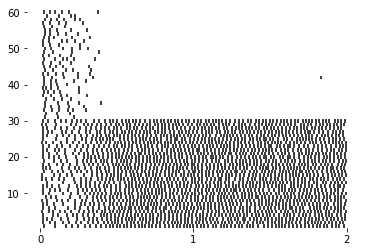

In [55]:
# Raster plot for trial #0 in the decision dataset
import matplotlib.pyplot as matplt
#import seaborn as sns

n_trial = 0
cur_spiketimes = np.concatenate([
    data_decision['data']['spikesx'][n_trial],
    data_decision['data']['spikesy'][n_trial]],
    axis = 0)

def plotRaster(spiketimes, **kwargs):
    """ function to plot raster plot for a given trial"""
    ax = matplt.gca()
    for neur in range(spiketimes.shape[0]):
        for spike in range(spiketimes.shape[1]):
            if spiketimes[neur,spike]>0:
                matplt.vlines(spiketimes[neur,spike]/1000, neur + .5, neur + 1.5, **kwargs)
    
    matplt.ylim(.5, spiketimes.shape[0] + .5)
    return ax

matf = matplt.figure(figsize=(6,4))

plotRaster(cur_spiketimes)
#sns.despine()
# Same as despine:
for d in ["left", "top", "bottom", "right"]:
    matplt.gca().spines[d].set_visible(False)
matplt.xticks([0,1,2])
#matplt.xlabel('t (sec)')
#matplt.ylabel('neuron number')
matplt.show()
matf.savefig("Figures/raster_decision.pdf", bbox_inches='tight')


In [16]:
# The FRED curve as inset on calcium simulation
simParams = GP_fit_saves[0][3]
tmp = fred_curve(simParams['fred_params'])
plt([plt_type.Scatter(x=tmp[0], y=tmp[1])])
save_csv("figure_4_5_fred_inset.csv",  np.stack(tmp).T)

In [61]:
# Example convolution (noiseless data)
# Create data with no noise to show examples
visParams = copy.deepcopy(simParams)
visParams['delta_t'] = 1
visParams['Sigma_calc_obs'] = 0
y_noiseless = createData(data_decision, visParams, batchnum=0)

# Show also the subsampled data used for fitting
y_noisy = GP_fit_saves[0][0]
y_noisy_obs_times = data_decision['data']['rt'][0][range(0, min(simParams['T_max'], data_decision['data']['rt'][0].shape[0]), simParams['delta_t'])]

# An example + and - neuron vs time on one trial 
all_plots = []

n_trial=0

all_plots.append(plt_type.Scatter(x=np.arange(y_noiseless.shape[1]), y = y_noiseless[:1, :, n_trial].mean(0)))
all_plots.append(plt_type.Scatter(x=np.arange(y_noiseless.shape[1]), y = y_noiseless[41:42, :, n_trial].mean(0)))
all_plots.append(plt_type.Scatter(x=y_noisy_obs_times, y = y_noisy[:1, :, n_trial].mean(0), mode='markers'))
all_plots.append(plt_type.Scatter(x=y_noisy_obs_times, y = y_noisy[41:42, :, n_trial].mean(0), mode='markers'))
    #all_plots.append(plt_type.Scatter(x=y[:30,:, n_trial].mean(0), y=y[-30:,:, n_trial].mean(0)))
    
plt(all_plots)

save_csv("figure_4_5_calc_nonoise0.csv", 
         np.stack([np.arange(y_noiseless.shape[1]), y_noiseless[:1, :, n_trial].mean(0)], axis=1))
save_csv("figure_4_5_calc_nonoise1.csv", 
         np.stack([np.arange(y_noiseless.shape[1]), y_noiseless[41:42:, :, n_trial].mean(0)], axis=1))
save_csv("figure_4_5_calc_sample0.csv", 
         np.stack([y_noisy_obs_times, y_noisy[:1, :, n_trial].mean(0)], axis=1))
save_csv("figure_4_5_calc_sample1.csv", 
         np.stack([y_noisy_obs_times, y_noisy[41:42, :, n_trial].mean(0)], axis=1))

#save_csv(("figure3_panel1_line2_ind%0.2d" % (i)) + ".csv", a[2])

# Figure GP fits

In [67]:
a[4]

array([[0.97809329, 2.70332707],
       [2.72672272, 0.96086633],
       [1.61962039, 1.63471993],
       [0.94400741, 2.46551804],
       [2.54539847, 0.91420885]])

In [62]:
i = 0
[a, cur_eigs] = plotSingle(GP_fit_saves[i], data_decision)

/nfs/nhome/live/gbohner/anaconda2/envs/thesis_env/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



In [34]:
# Decision making fit
i = 0
[a, cur_eigs] = plotSingle(GP_fit_saves[i], data_decision)

# Line1 - Quiver plot (simply coordinates, do styling in latex)
save_csv(("figure_4_5_gpfit_line1_ind%0.2d" % (i)) + ".csv", np.concatenate([a[0], a[1]],axis=1))

# Line2 - Nullcline1
save_csv(("figure_4_5_gpfit_line2_ind%0.2d" % (i)) + ".csv", a[2])

# Line3 - Nullcline2
save_csv(("figure_4_5_gpfit_line3_ind%0.2d" % (i)) + ".csv", a[3])

# Line4 - Fixed point coordinates, sizes as 3rd column and (color as 4th column) # Python plot marker size: a[-2].marker.size[:,None]
save_csv(("figure_4_5_gpfit_line4_ind%0.2d" % (i)) + ".csv", np.concatenate([a[4], a[5], cur_eigs],axis=1))

/nfs/nhome/live/gbohner/anaconda2/envs/thesis_env/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



In [35]:
# Loading fit
i = 1
[a, cur_eigs] = plotSingle(GP_fit_saves[i], data_loading_even)

# Line1 - Quiver plot (simply coordinates, do styling in latex)
save_csv(("figure_4_5_gpfit_line1_ind%0.2d" % (i)) + ".csv", np.concatenate([a[0], a[1]],axis=1))

# Line2 - Nullcline1
save_csv(("figure_4_5_gpfit_line2_ind%0.2d" % (i)) + ".csv", a[2])

# Line3 - Nullcline2
save_csv(("figure_4_5_gpfit_line3_ind%0.2d" % (i)) + ".csv", a[3])

# Line4 - Fixed point coordinates, sizes as 3rd column and (color as 4th column) # Python plot marker size: a[-2].marker.size[:,None]
save_csv(("figure_4_5_gpfit_line4_ind%0.2d" % (i)) + ".csv", np.concatenate([a[4], a[5], cur_eigs],axis=1))

/nfs/nhome/live/gbohner/anaconda2/envs/thesis_env/lib/python3.7/site-packages/ipykernel/__main__.py:18: ComplexWarning:

Casting complex values to real discards the imaginary part

/nfs/nhome/live/gbohner/anaconda2/envs/thesis_env/lib/python3.7/site-packages/autograd/numpy/numpy_vjps.py:444: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



In [ ]:
for i in [0,1]:
    [a, cur_eigs] = plotSingle(GP_fit_saves[i], data_excitation[i])

    # We need the traces for training data, GP variances and fixed points

    # Line1 - Quiver plot (simply coordinates, do styling in latex)
    save_csv(("figure3_panel1_line1_ind%0.2d" % (i)) + ".csv", np.concatenate([a[0], a[1]],axis=1))

    # Line2 - Nullcline1
    save_csv(("figure3_panel1_line2_ind%0.2d" % (i)) + ".csv", a[2])

    # Line3 - Nullcline2
    save_csv(("figure3_panel1_line3_ind%0.2d" % (i)) + ".csv", a[3])

    # Line4 - Fixed point coordinates, sizes as 3rd column and (color as 4th column) # Python plot marker size: a[-2].marker.size[:,None]
    save_csv(("figure3_panel1_line4_ind%0.2d" % (i)) + ".csv", np.concatenate([a[4], a[5], cur_eigs],axis=1))

# Figure 3B - Eigenvalues of middle point

In [ ]:
excitation_values_true = 1.5 + 0.01*np.array(excitation_values)

In [ ]:
all_eigvals = np.zeros((0,2))
mean_evecs = np.zeros((2,2))

for i in range(len(GP_fit_saves)):
    
    [y_train, x_train,
     all_results, simParams,
     init_paramvec, dict_ind, dict_shape, opt_params, 
     bnds, transforms] = GP_fit_saves[i]

    paramvec = replace_params(all_results[-1].x, opt_params, init_paramvec)
    paramdict = vec_to_params(paramvec, dict_ind, dict_shape, transforms)

    # Unpack the usual parameters
    (Sigma_eps, mu_0_0, Sigma_0_0, C, Sigma_nu, z, u, Sigma_u, lengthscales, kernel_variance, s, J)  = \
        paramdict.values()[:12]

    if np.any(np.isnan(lengthscales)):
        set_trace()

    # Deal with the extra possible parameters
    Sigma_s = None; Sigma_J=None;
    if 'Sigma_s' in paramdict.keys():
        Sigma_s = paramdict['Sigma_s']
    if 'Sigma_J' in paramdict.keys():
        Sigma_J = paramdict['Sigma_J']

    # Get the middle fixed point in every case
    mid_ind = np.argsort((s[0,:]-s[1,:])**2)[0]
    
    #print s[:,mid_ind], mid_ind
    
    [evs, evecs] = np.linalg.eig(paramdict['J'][mid_ind,:,:])
    ev_inds = np.argsort(evs)
    
    all_eigvals = np.concatenate([all_eigvals, evs[ev_inds,None].T], axis=0)
    mean_evecs = mean_evecs + evecs[:,ev_inds]
    
mean_evecs = mean_evecs / (1.0*len(GP_fit_saves))

# Line1 and 2 - Eigenvalues of middle point vs excitation (simply coordinates, do styling in latex)
save_csv("figure3_panel2_line1" + ".csv", np.concatenate([excitation_values_true[:,None], all_eigvals],axis=1))

# Line 3 - Mean eigenvector directions
save_csv("figure3_panel2_line2" + ".csv", np.concatenate([np.zeros((2,2)), mean_evecs.T],axis=1))


In [ ]:
mean_evecs

In [ ]:
# Line5 - Fixed point coordinates, sizes as 3rd column and (color as 4th column) # Python plot marker size: a[-2].marker.size[:,None]
save_csv("figure2_panel3_line1.csv", np.concatenate([all_r_vals, all_x_vals, all_sizes, all_color_inds],axis=1))

In [76]:
[y_train, x_train,
 all_results, simParams,
 init_paramvec, dict_ind, dict_shape, opt_params, 
 bnds, transforms] = GP_fit_saves[0]

paramvec = replace_params(all_results[-1].x, opt_params, init_paramvec)
paramdict = vec_to_params(paramvec, dict_ind, dict_shape, transforms)

# Unpack the usual parameters
(Sigma_eps, mu_0_0, Sigma_0_0, C, Sigma_nu, z, u, Sigma_u, lengthscales, kernel_variance, s, J, Sigma_s)  = \
    paramdict.values()

In [77]:
s.T

array([[0.97809329, 2.70332707],
       [2.72672272, 0.96086633],
       [1.61962039, 1.63471993],
       [0.94400741, 2.46551804],
       [2.54539847, 0.91420885]])

In [71]:
cur_eigs

array([[-0.02512618,  0.06914269],
       [ 0.08207475,  0.1608266 ],
       [ 0.01583239,  2.45700798],
       [ 0.54712395,  0.94326405],
       [ 0.63185693,  0.98178649]])

In [73]:
Sigma_s.flatten()

array([0.01686837, 0.51026489, 0.71033361, 1.66168465, 1.77146966])